# 数据预处理

In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers.legacy import Adam
from datetime import datetime
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Permute, Reshape, Multiply
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout

In [2]:
df = pd.read_csv('/Users/harvey/Desktop/quant2/FE/final_data_20240303.csv')

In [3]:
# 找到第一个空值出现的位置
first_null_position = df.isnull().any(axis=1).idxmin()

In [4]:
df = df[first_null_position:]

In [5]:
df = df.set_index('Date')

In [6]:
df.isnull().values.any()

False

In [7]:
# 将索引转换为datetime类型
df.index = pd.to_datetime(df.index)

df['day_of_week'] = df.index.dayofweek

# 将星期几的数字转换为星期几的名称，这一步是可选的，只是为了使输出更易于理解
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['day_of_week_name'] = df['day_of_week'].apply(lambda x: days[x])

# 使用get_dummies进行One-Hot编码
week_dummies = pd.get_dummies(df['day_of_week_name'], prefix='day')

# 将One-Hot编码后的DataFrame合并回原DataFrame
df = pd.concat([df, week_dummies], axis=1)

# 删除中间列（如果不需要）
df.drop(['day_of_week', 'day_of_week_name'], axis=1, inplace=True)

# 创建新特征：一年中的第几周
df['week_of_year'] = df.index.isocalendar().week

# 创建新特征：每天的第几个小时
df['hour_of_day'] = df.index.hour

In [8]:
df

,time,open,high,low,close,volume,SMA_5,SMA_10,SMA_20,SMA_50,...,Momentum_20,Momentum_50,Momentum_100,day_Friday,day_Monday,day_Thursday,day_Tuesday,day_Wednesday,week_of_year,hour_of_day
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02 05:55:00,2024-01-02T05:55:00,408.77,408.77,408.41,408.49,23957,408.816,408.852,408.9875,409.137942,...,-0.77,-0.8100,-0.8800,False,False,False,True,False,1,5
2024-01-02 06:00:00,2024-01-02T06:00:00,408.42,408.46,408.42,408.46,969,408.720,408.816,408.9530,409.123142,...,-0.69,-0.7400,-0.8200,False,False,False,True,False,1,6
2024-01-02 06:05:00,2024-01-02T06:05:00,408.55,408.59,407.82,407.94,21034,408.502,408.710,408.8905,409.097542,...,-1.25,-1.2800,-1.1800,False,False,False,True,False,1,6
2024-01-02 06:10:00,2024-01-02T06:10:00,408.00,408.03,407.60,407.60,15179,408.234,408.572,408.8060,409.065142,...,-1.69,-1.6200,-1.5000,False,False,False,True,False,1,6
2024-01-02 06:15:00,2024-01-02T06:15:00,407.55,407.55,406.65,406.70,25226,407.838,408.364,408.6775,409.013400,...,-2.57,-2.5871,-2.2900,False,False,False,True,False,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 19:35:00,2024-03-01T19:35:00,445.39,445.40,445.39,445.39,2465,445.364,445.320,445.2525,445.362740,...,0.33,-0.3500,2.5800,True,False,False,False,False,9,19
2024-03-01 19:40:00,2024-03-01T19:40:00,445.40,445.40,445.40,445.40,947,445.384,445.330,445.2630,445.356640,...,0.21,-0.3050,2.3700,True,False,False,False,False,9,19
2024-03-01 19:45:00,2024-03-01T19:45:00,445.35,445.35,445.35,445.35,765,445.384,445.339,445.2780,445.352640,...,0.30,-0.2000,2.5700,True,False,False,False,False,9,19


# 普通预测

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 假设 df 是您的 DataFrame

# 数据准备
features = df.drop(['close', 'time', 'open', 'high', 'low'], axis=1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_label = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_label.fit_transform(df[['close']])

scaled_features = np.hstack((scaled_features, scaled_close))


time_step=96*3

future_step=13

from keras import backend as K




# 修改create_dataset以预测未来48个数据点
# def create_dataset(data, time_step, future_step):
#     X, Y = [], []
#     for i in range(len(data) - time_step - future_step):
#         a = data[i:(i + time_step), :-1]  # 特征
#         X.append(a)
#         Y.append(data[(i + time_step):(i + time_step + future_step), -1])  # 'close'列的未来48个数据点
#     return np.array(X), np.array(Y)

def create_dataset(data, time_step, future_step):
    X, Y = [], []
    for i in range(len(data) - time_step - future_step):
        a = data[i:(i + time_step), :-1]  # 特征
        X.append(a)
        # 修改这里，只选择未来第future_step个数据点作为输出
        Y.append(data[i + time_step + future_step - 1, -1])  # 'close'列的未来第future_step个数据点
    return np.array(X), np.array(Y)



# 应用修改后的时间步长
X, y = create_dataset(scaled_features, time_step=time_step, future_step=future_step)

# 划分训练集和测试集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='glorot_uniform'),
#     LSTM(50, return_sequences=False),
#     Dense(future_step)
# ])

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # 添加Dropout层，丢弃率为20%
    LSTM(100, return_sequences=True),
    Dropout(0.2),  # 再次添加Dropout层
    LSTM(100),
    Dense(1)  # 修改这里，使模型只输出单一的预测结果
])


# model = Sequential([
#     LSTM(100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dense(1)  # 修改这里，使模型只输出单一的预测结果
# ])






          

# 定义自定义损失函数
# def custom_loss(y_true, y_pred):
#     y_pred_last = y_pred[:, -1]
#     y_true_last = y_true[:, -1]
#     return K.mean(K.square(y_pred_last - y_true_last), axis=-1)




early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# def custom_loss(y_true, y_pred):
#     weights = K.arange(1, K.shape(y_true)[-1] + 1, dtype=K.floatx())  # 加权因子
#     mse = K.square(y_pred - y_true)
#     weighted_mse = mse * weights  # 加权均方误差
#     return K.mean(weighted_mse, axis=-1)

optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # clipvalue是梯度裁剪的阈值
model.compile(optimizer=optimizer,loss='mean_squared_error')



model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64, verbose=1, callbacks=[early_stopping])


# # 第一阶段，使用所有数据训练
# model.fit(X_train, y_train, epochs=50, batch_size=64)

# # 第二阶段，仅使用最近50%的数据
# recent_X_train = X_train[int(len(X_train) * 0.5):]
# recent_y_train = y_train[int(len(y_train) * 0.5):]
# model.fit(recent_X_train, recent_y_train, epochs=30, batch_size=32)

# # 第三阶段，仅使用最近25%的数据进行微调
# more_recent_X_train = X_train[int(len(X_train) * 0.75):]
# more_recent_y_train = y_train[int(len(y_train) * 0.75):]
# model.fit(more_recent_X_train, more_recent_y_train, epochs=20, batch_size=16
          
          
        
        

# 预测和可视化
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)



Epoch 1/3
96/96 [==============================] - 62s 628ms/step - loss: 0.0122 - val_loss: 0.0015
Epoch 2/3
96/96 [==============================] - 60s 629ms/step - loss: 0.0011 - val_loss: 7.9799e-04
Epoch 3/3
192/192 [==============================] - 21s 109ms/step


In [10]:
len(X_train)

6136

In [11]:
y_pred.shape

(1534, 1)

In [12]:
X_test.shape

(1534, 288, 38)

In [13]:
len(y_train_pred)

6136

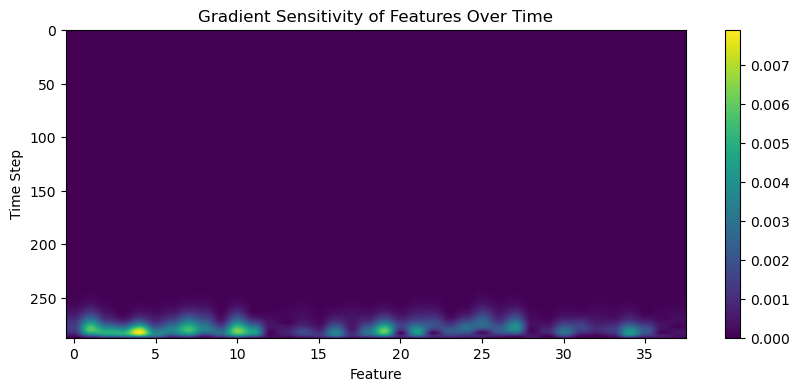

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 确保我们在Eager Execution模式下（TensorFlow 2.x默认启用）
assert tf.executing_eagerly()

# 将NumPy数组转换为TensorFlow张量
sample_to_analyze = tf.convert_to_tensor(X_test[0:1])

# 使用GradientTape来记录计算过程，以便自动获取梯度
with tf.GradientTape() as tape:
    # 将输入数据标记为需要梯度信息的张量
    tape.watch(sample_to_analyze)
    
    # 通过模型前向传播得到预测结果
    prediction = model(sample_to_analyze)
    
# 计算输入相对于预测结果的梯度
grads = tape.gradient(prediction, sample_to_analyze)

# 梯度的绝对值可以被看作是模型对每个输入特征的重视程度
grads_abs = np.abs(grads.numpy())

# 可视化
plt.figure(figsize=(10, 4))
plt.imshow(grads_abs[0], cmap='viridis', aspect='auto')
plt.colorbar()
plt.ylabel('Time Step')
plt.xlabel('Feature')
plt.title('Gradient Sensitivity of Features Over Time')
plt.show()


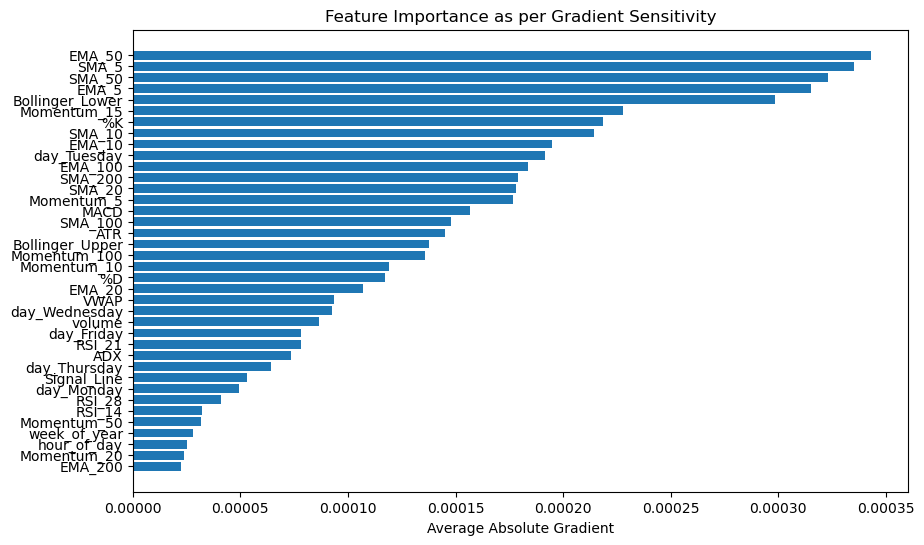

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 假设X_test已经是tf.Tensor，如果不是，使用tf.convert_to_tensor转换
# 假设features_names包含了除去不参与训练的特征（'close', 'time', 'open', 'high', 'low'）后的所有特征名称
features_names = list(features.columns) + ['close']

# 选择一个样本进行分析
sample_to_analyze = tf.convert_to_tensor(X_test[0:1], dtype=tf.float32)

# 使用GradientTape来记录计算过程，以便自动获取梯度
with tf.GradientTape() as tape:
    tape.watch(sample_to_analyze)
    prediction = model(sample_to_analyze)

# 计算输入相对于预测结果的梯度
grads = tape.gradient(prediction, sample_to_analyze)
grads_abs = np.abs(grads.numpy())

# 计算每个特征的平均梯度绝对值
mean_grads_abs = np.mean(grads_abs, axis=(0,1))

# 将特征名称和对应的平均梯度绝对值绑定在一起，然后按梯度绝对值排序
features_grads = zip(features_names, mean_grads_abs)
sorted_features_grads = sorted(features_grads, key=lambda x: x[1], reverse=True)

# 分别解压特征名称和对应的排序后的梯度绝对值
sorted_features, sorted_grads = zip(*sorted_features_grads)

# 可视化
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_grads, tick_label=sorted_features)
plt.xlabel('Average Absolute Gradient')
plt.title('Feature Importance as per Gradient Sensitivity')
plt.gca().invert_yaxis()  # 将最重要的特征显示在顶部
plt.show()


In [16]:
y_train_pred.shape

(6136, 1)

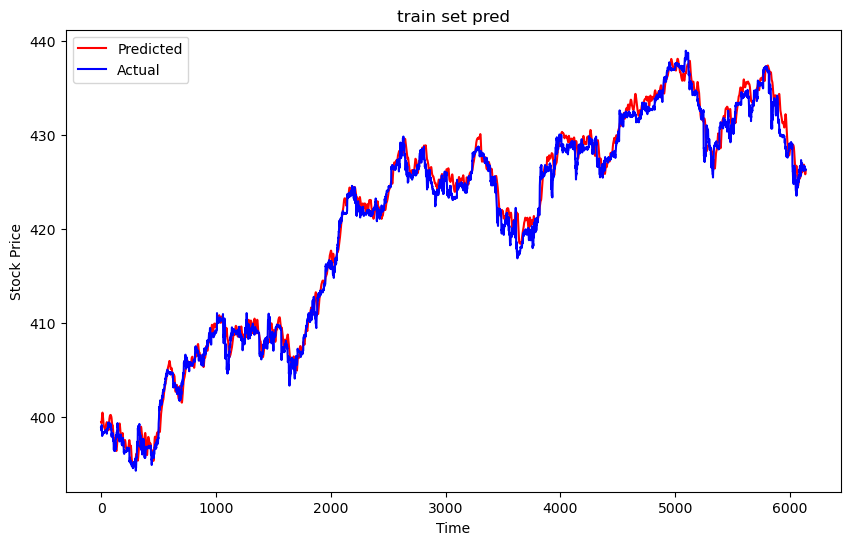

In [17]:
import matplotlib.pyplot as plt

# 由于y_pred可能是二维的，且只有一列，我们首先确保它是一维的
if y_pred.ndim > 1:
    y_pred = y_pred.squeeze()

# 逆缩放预测和测试集的数据
y_train_pred_rescaled = scaler_label.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_rescaled = scaler_label.inverse_transform(y_train.reshape(-1, 1))

# 绘制预测值和实际值
plt.figure(figsize=(10, 6))  # 可以调整图形大小
plt.plot(y_train_pred_rescaled, label='Predicted', color='red')  # 预测值
plt.plot(y_train_rescaled, label='Actual', color='blue')  # 实际值
plt.title('train set pred')  # 图表标题
plt.xlabel('Time')  # X轴标签
plt.ylabel('Stock Price')  # Y轴标签
plt.legend()  # 显示图例
plt.show()


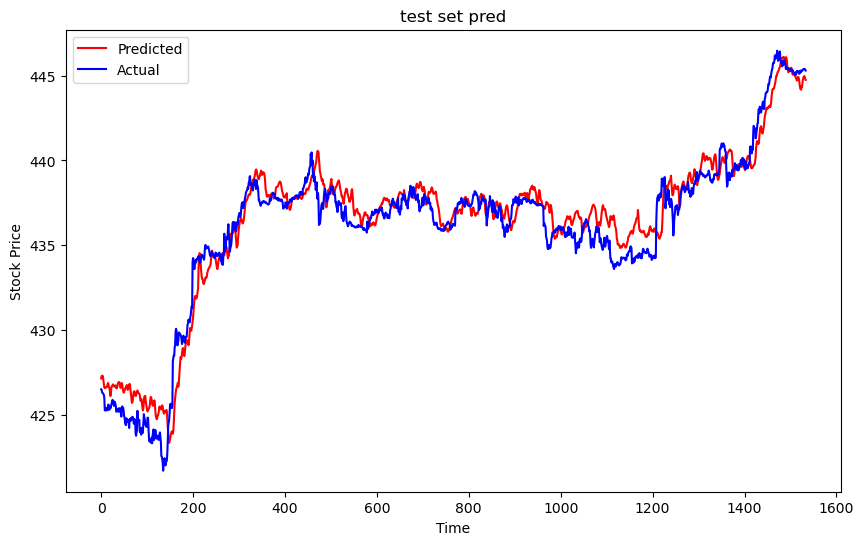

In [167]:
import matplotlib.pyplot as plt

# 由于y_pred可能是二维的，且只有一列，我们首先确保它是一维的
if y_pred.ndim > 1:
    y_pred = y_pred.squeeze()

# 逆缩放预测和测试集的数据
y_pred_rescaled = scaler_label.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_label.inverse_transform(y_test.reshape(-1, 1))

# 绘制预测值和实际值
plt.figure(figsize=(10, 6))  # 可以调整图形大小
plt.plot(y_pred_rescaled, label='Predicted', color='red')  # 预测值
plt.plot(y_test_rescaled, label='Actual', color='blue')  # 实际值
plt.title('test set pred')  # 图表标题
plt.xlabel('Time')  # X轴标签
plt.ylabel('Stock Price')  # Y轴标签
plt.legend()  # 显示图例
plt.show()


In [168]:
y_pred_rescaled.shape

(1534, 1)

In [169]:
y_test_rescaled.shape

(1534, 1)

# 计算回报

In [170]:
test_start_position_direct = len(y_train)+time_step

In [171]:
test_df = df.iloc[test_start_position_direct:test_start_position_direct+len(y_test)]

In [172]:
test_df['predicted_close_in1h'] = y_pred_rescaled.squeeze()
test_df['actual_close_in1h'] = y_test_rescaled.squeeze()

/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_63222/1096888416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_close_in1h'] = y_pred_rescaled.squeeze()
/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_63222/1096888416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['actual_close_in1h'] = y_test_rescaled.squeeze()


In [173]:
df_1h_magnify = test_df[['close','actual_close_in1h','predicted_close_in1h']]

In [174]:
df_1h_magnify['true_updown_in1h'] = df_1h_magnify['actual_close_in1h']/df_1h_magnify['close'] - 1
df_1h_magnify['predict_updown_in1h'] = df_1h_magnify['predicted_close_in1h']/df_1h_magnify['close'] - 1

/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_63222/2636791147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1h_magnify['true_updown_in1h'] = df_1h_magnify['actual_close_in1h']/df_1h_magnify['close'] - 1
/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_63222/2636791147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1h_magnify['predict_updown_in1h'] = df_1h_magnify['predicted_close_in1h']/df_1h_magnify['close'] - 1


In [175]:
df_1h_magnify['close'].shift(-12).round(4) == df_1h_magnify['actual_close_in1h'].round(4)

Date
2024-02-20 18:20:00     True
2024-02-20 18:25:00     True
2024-02-20 18:30:00     True
2024-02-20 18:35:00     True
2024-02-20 18:40:00     True
                       ...  
2024-03-01 18:15:00    False
2024-03-01 18:20:00    False
2024-03-01 18:25:00    False
2024-03-01 18:30:00    False
2024-03-01 18:40:00    False
Length: 1534, dtype: bool

In [176]:
df_1h_magnify = df_1h_magnify.dropna(how='any')

df_1h_magnify['direction_same'] = (df_1h_magnify['true_updown_in1h'] * df_1h_magnify['predict_updown_in1h']) > 0

# 计算方向相同的次数
direction_same_count = df_1h_magnify['direction_same'].sum()

direction_same_count/len(df_1h_magnify)

0.5149934810951761

In [177]:
df_1h_magnify.to_csv('test.csv')

In [178]:
df_1h_magnify['true_updown_in1h'].quantile(0.05)

-0.002884004692976605

In [179]:
df_1h_magnify['true_updown_in1h'].quantile(0.95)

0.00366049778045248

In [180]:
df_1h_magnify

,close,actual_close_in1h,predicted_close_in1h,true_updown_in1h,predict_updown_in1h,direction_same
Date,,,,,,
2024-02-20 18:20:00,426.64,426.5100,427.151154,-3.047065e-04,0.001198,False
2024-02-20 18:25:00,426.68,426.4799,427.281342,-4.689697e-04,0.001409,False
2024-02-20 18:30:00,426.53,426.3400,427.249023,-4.454552e-04,0.001686,False
2024-02-20 18:35:00,426.39,426.3000,427.315216,-2.110744e-04,0.002170,False
2024-02-20 18:40:00,426.29,426.2800,427.229675,-2.345821e-05,0.002204,False
...,...,...,...,...,...,...
2024-03-01 18:15:00,445.26,445.4000,444.915283,3.144230e-04,-0.000774,False
2024-03-01 18:20:00,445.20,445.3900,444.978058,4.267745e-04,-0.000499,False
2024-03-01 18:25:00,445.11,445.4000,444.902496,6.515243e-04,-0.000466,False


# 模型表现

In [181]:
#config

buy_threshold = 0.003
sell_threshold = -0.002

In [182]:
# 初始化资金和仓位
initial_capital = 1000
buy_unit = 1000
capital = initial_capital
position = 0  # 当前仓位，正数为持有，负数为卖空
trade_count = 0  # 交易次数
waiting_period = 0  # 等待期间的计数器，用于自动平仓
capital_list = []
total_asset_list = []  # 资产总价值列表
trade_signals = [0] * len(df_1h_magnify)


for i, (index, row) in enumerate(df_1h_magnify.iterrows()):
    
    predict_change_rate = row['predict_updown_in1h']
    
    # 每五分钟检查一次，如果有持仓且等待期间到了，自动平仓
    if waiting_period > 0:
        waiting_period -= 1
        if waiting_period == 0 and position != 0:
            capital += position * row['close']
            position = 0  # 清仓

    # 买入信号处理
    if predict_change_rate > buy_threshold:
    #if predict_change_rate < sell_threshold:

        trade_signals[i] = 1  # 买入信号
        if position <= 0:  # 如果仓位为负或为0，则买入
            if position < 0:
                # 如果已有持仓，则先平仓
                capital += position * row['close']
            # 买入
            position = buy_unit / row['close']
            capital -= position * row['close']
            waiting_period = 12  # 设置等待期间为12个时间点，即一个小时
            trade_count += 1
        else:
            # 仓位为正，重置等待期间
            waiting_period = 12

    # 卖出信号处理
    elif predict_change_rate < sell_threshold:
    #elif predict_change_rate > buy_threshold:
        
        trade_signals[i] = -1  # 卖出信号
        if position >= 0:  # 如果仓位为正或为0，则卖空
            if position > 0:
                # 如果已有持仓，则先平仓
                capital += position * row['close']
            # 卖空
            position = -buy_unit / row['close']
            capital += abs(position) * row['close']
            waiting_period = 12  # 设置等待期间为12个时间点，即一个小时
            trade_count += 1
        else:
            # 仓位为负，重置等待期间
            waiting_period = 12
    total_asset_value = capital + (position * row['close'])
    total_asset_list.append(total_asset_value)
        
    # 检查是否是DataFrame的最后一行
    if index == df_1h_magnify.index[-1] and position != 0:
        # 如果是最后一期，则关闭所有仓位
        capital += position * row['close']
        position = 0  # 清仓
    capital_list.append(capital)

# 计算总回报
total_return = capital - initial_capital
df_1h_magnify['capital_list'] = capital_list
df_1h_magnify['total_asset_list'] = total_asset_list

In [183]:
total_return

18.775999356828606

In [184]:
df_1h_magnify['capital_list'][-1]/1000-1

0.01877599935682861

In [185]:
df_1h_magnify['close'][-1]/df_1h_magnify['close'][0] -1

0.0437371085692857

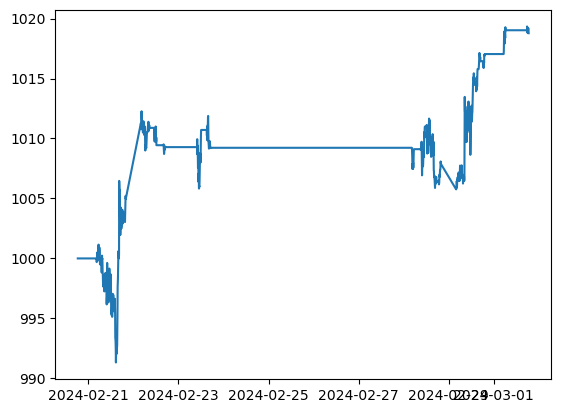

In [186]:
plt.plot(df_1h_magnify.index,df_1h_magnify['total_asset_list'])

In [187]:
import numpy as np

# 假设 df_1h_magnify['close'] 存在且已经有了 total_asset_list
close_prices = df_1h_magnify['close'].values
normalized_close_prices = close_prices / close_prices[0]  # 归一化收盘价

total_assets = np.array(total_asset_list)
normalized_total_assets = total_assets / total_assets[0]  # 归一化资产总价值

# 更新DataFrame，以便比较
df_1h_magnify['normalized_close'] = normalized_close_prices
df_1h_magnify['normalized_total_assets'] = normalized_total_assets

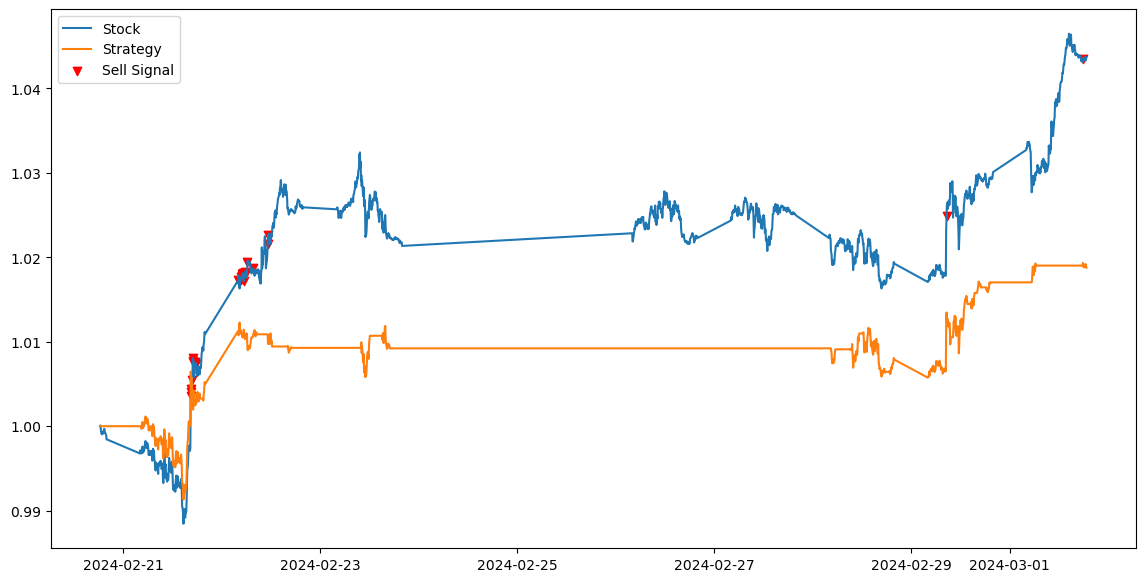

In [188]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 设置图像大小
plt.figure(figsize=(14, 7))


# 添加买入卖出标记，使用不同颜色区分买入和卖出
buy_signals = [i for i, signal in enumerate(trade_signals) if signal == 1]
sell_signals = [i for i, signal in enumerate(trade_signals) if signal == -1]

# 绘制归一化的收盘价和资产总价值
plt.plot(df_1h_magnify.index, df_1h_magnify['normalized_close'], label='Stock')
plt.plot(df_1h_magnify.index, df_1h_magnify['normalized_total_assets'], label='Strategy')

# 添加买入卖出标记，使用不同颜色区分买入和卖出
# 这次直接使用有效的索引列表进行绘制
#plt.scatter(df_1h_magnify.index[buy_signals], df_1h_magnify['normalized_close'].iloc[buy_signals], color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(df_1h_magnify.index[sell_signals], df_1h_magnify['normalized_close'].iloc[sell_signals], color='red', label='Sell Signal', marker='v', alpha=1)

plt.legend()
plt.show()

In [189]:
sell_signals

[168,
 169,
 170,
 172,
 174,
 175,
 176,
 181,
 182,
 183,
 211,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 228,
 229,
 230,
 231,
 232,
 238,
 253,
 297,
 298,
 1221,
 1523]

In [190]:
buy_signals

[23,
 24,
 25,
 26,
 29,
 30,
 31,
 39,
 40,
 44,
 45,
 46,
 47,
 52,
 55,
 56,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 87,
 88,
 89,
 90,
 94,
 95,
 96,
 97,
 98,
 99,
 102,
 103,
 108,
 109,
 110,
 111,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 127,
 128,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 151,
 152,
 153,
 154,
 155,
 166,
 167,
 204,
 205,
 355,
 356,
 473,
 486,
 487,
 535,
 536,
 539,
 545,
 546,
 547,
 548,
 980,
 981,
 1036,
 1037,
 1038,
 1044,
 1045,
 1046,
 1051,
 1074,
 1076,
 1077,
 1078,
 1083,
 1084,
 1092,
 1093,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1108,
 1109,
 1110,
 1114,
 1115,
 1116,
 1117,
 1119,
 1120,
 1121,
 1122,
 1127,
 1128,
 1150,
 1151,
 1152,
 1153,
 1154,
 1155,
 1158,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167,
 1168,
 1169,
 1170,
 1171,
 1172,
 1173,
